In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv('../data/classification_model_data.csv', encoding='latin1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139364 entries, 0 to 139363
Columns: 155 entries, female to economy_Zimbabwe
dtypes: bool(137), int64(18)
memory usage: 37.3 MB


In [5]:
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

In [4]:
df['worry_level'].value_counts()

worry_level
-1    58031
 1    48216
 0    33117
Name: count, dtype: int64

## Logistic Regression

In [21]:
X = df.drop(columns=['worry_level'])
y = df['worry_level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
log_reg = LogisticRegression()

In [24]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

c:\Users\Mezzow Tecnologia\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# avaliando o modelo
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          -1       0.60      0.74      0.67     11646
           0       0.33      0.01      0.02      6593
           1       0.53      0.73      0.61      9634

    accuracy                           0.57     27873
   macro avg       0.49      0.49      0.43     27873
weighted avg       0.51      0.57      0.49     27873

Confusion Matrix:
[[8648   49 2949]
 [3164   54 3375]
 [2523   63 7048]]
Accuracy Score:
0.5650629641588634


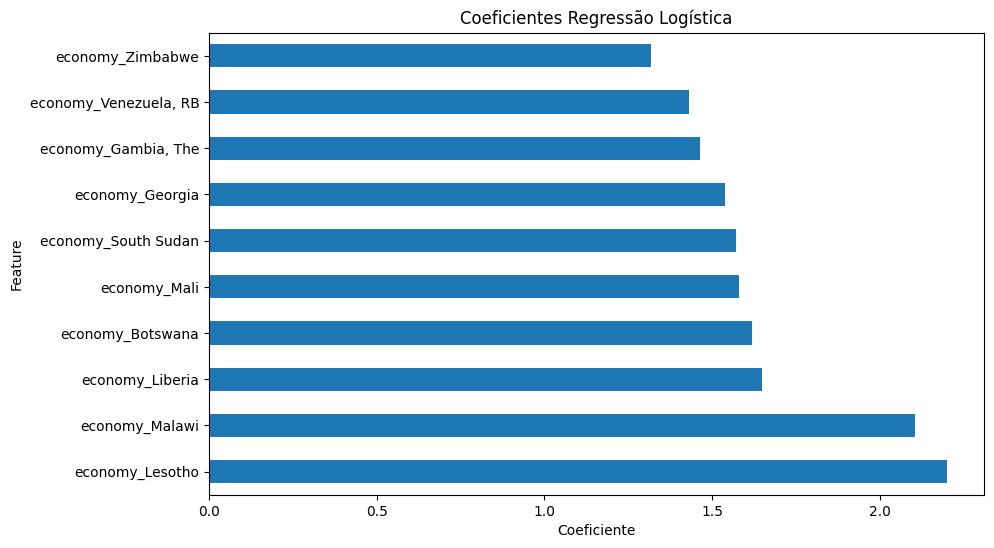

In [12]:
# visualizando coeficientes
coef = log_reg.coef_[0]
features = X.columns

coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coef})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

coef_df.head(10).plot(kind='barh', x='Feature', y='Coefficient', legend=False, figsize=(10, 6))
plt.title('Coeficientes Regressão Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Feature')
plt.show()

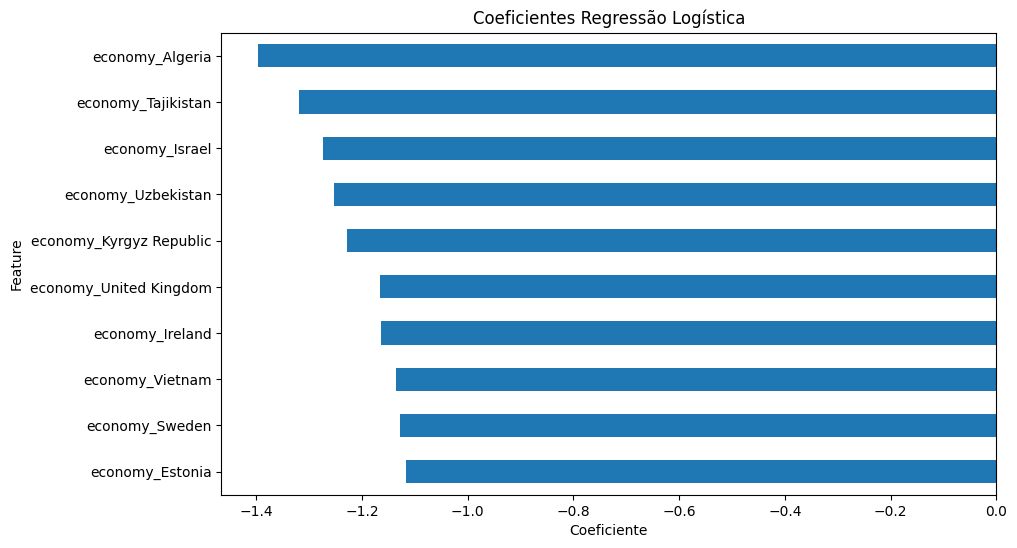

In [13]:
coef_df.tail(10).plot(kind='barh', x='Feature', y='Coefficient', legend=False, figsize=(10, 6))
plt.title('Coeficientes Regressão Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Feature')
plt.show()

## Random Forrest

In [7]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
rf_predictions = rf.predict(X_test)

In [9]:
print('Random Forest Model Performance:')

print('Classification Report:')

print(classification_report(y_test, rf_predictions))

Random Forest Model Performance:
Classification Report:
              precision    recall  f1-score   support

          -1       0.63      0.70      0.67     11646
           0       0.32      0.19      0.24      6593
           1       0.57      0.66      0.61      9634

    accuracy                           0.56     27873
   macro avg       0.51      0.51      0.50     27873
weighted avg       0.54      0.56      0.54     27873



## Neural Network

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

In [12]:
# Converter rótulos ordinais para rótulos binários cumulativos para regressão ordinal.
# Aqui, assumimos que os valores de worry_level estão em {-1, 0, 1}. Primeiro, mapeamos para {0, 1, 2} adicionando 1.
# Em seguida, o vetor binário para cada instância é:
#   binary[j] = 1 se (y+1) > j, senão 0, para j em range(num_thresholds)
def convert_to_binary(y):
    # y: tensor de rótulos ordinais (por exemplo, -1,0,1)
    new_y = y + 1
    batch_size = new_y.shape[0]
    num_thresholds = 2
    binary = torch.zeros((batch_size, num_thresholds))
    for j in range(num_thresholds):
        binary[:, j] = (new_y > j).float()
    return binary

# Criar uma divisão de validação a partir de X_train e y_train (80% treino / 20% validação)
X_train_nn, X_val, y_train_nn, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          stratify=y_train)

In [13]:
# Converter DataFrames/Series do pandas para tensores torch.
X_train_tensor = torch.tensor(X_train_nn.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_nn.values, dtype=torch.int64)
y_train_binary = convert_to_binary(y_train_tensor)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.int64)
y_val_binary = convert_to_binary(y_val_tensor)

# Criar TensorDatasets e DataLoaders.
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_binary)
val_dataset = TensorDataset(X_val_tensor, y_val_binary)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Definir uma rede neural simples para regressão ordinal.
class OrdinalRegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_thresholds):
        super(OrdinalRegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_thresholds)  # saídas logits para cada limiar

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        logits = self.fc2(out)
        return logits

input_dim = X_train_tensor.shape[1]
hidden_dim = 64
num_thresholds = 2  # Para 3 classes ordinais

model = OrdinalRegressionNN(input_dim, hidden_dim, num_thresholds)

In [17]:
# Definir a função de perda e o otimizador.
# Usamos BCEWithLogitsLoss porque nossa rede produz logits para cada decisão binária.
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loop de treinamento com tqdm para rastreamento de progresso e coleta de perdas de treino e validação.
num_epochs = 20
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_batches = 0
    for batch_x, batch_y in tqdm(train_loader, desc=f"Época de Treino {epoch+1}"):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_batches += 1
    avg_train_loss = running_loss / train_batches
    train_loss_history.append(avg_train_loss)
    
    # Avaliar no conjunto de validação
    model.eval()
    val_running_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for val_x, val_y in tqdm(val_loader, desc=f"Época de Validação {epoch+1}"):
            val_outputs = model(val_x)
            val_loss = criterion(val_outputs, val_y)
            val_running_loss += val_loss.item()
            val_batches += 1
    avg_val_loss = val_running_loss / val_batches
    val_loss_history.append(avg_val_loss)
    
    print(f"Época {epoch+1}/{num_epochs}, Perda de Treino: {avg_train_loss:.4f}, Perda de Validação: {avg_val_loss:.4f}")

Época de Validação 1: 100%|██████████| 349/349 [00:00<00:00, 983.29it/s]


Época 1/20, Perda de Treino: 0.5416, Perda de Validação: 0.5087


Época de Validação 2: 100%|██████████| 349/349 [00:00<00:00, 1373.64it/s]


Época 2/20, Perda de Treino: 0.5118, Perda de Validação: 0.5061


Época de Validação 3: 100%|██████████| 349/349 [00:00<00:00, 1383.40it/s]


Época 3/20, Perda de Treino: 0.5090, Perda de Validação: 0.5097


Época de Validação 4: 100%|██████████| 349/349 [00:00<00:00, 918.96it/s] 


Época 4/20, Perda de Treino: 0.5067, Perda de Validação: 0.5150


Época de Validação 5: 100%|██████████| 349/349 [00:00<00:00, 1419.97it/s]


Época 5/20, Perda de Treino: 0.5055, Perda de Validação: 0.5009


Época de Validação 6: 100%|██████████| 349/349 [00:00<00:00, 1358.83it/s]


Época 6/20, Perda de Treino: 0.5037, Perda de Validação: 0.5043


Época de Validação 7: 100%|██████████| 349/349 [00:00<00:00, 902.93it/s] 


Época 7/20, Perda de Treino: 0.5032, Perda de Validação: 0.4995


Época de Validação 8: 100%|██████████| 349/349 [00:00<00:00, 1362.31it/s]


Época 8/20, Perda de Treino: 0.5020, Perda de Validação: 0.4987


Época de Validação 9: 100%|██████████| 349/349 [00:00<00:00, 1322.12it/s]


Época 9/20, Perda de Treino: 0.5016, Perda de Validação: 0.4997


Época de Validação 10: 100%|██████████| 349/349 [00:00<00:00, 1362.98it/s]


Época 10/20, Perda de Treino: 0.5007, Perda de Validação: 0.4983


Época de Validação 11: 100%|██████████| 349/349 [00:00<00:00, 1322.05it/s]


Época 11/20, Perda de Treino: 0.4993, Perda de Validação: 0.4991


Época de Validação 12: 100%|██████████| 349/349 [00:00<00:00, 1338.39it/s]


Época 12/20, Perda de Treino: 0.4990, Perda de Validação: 0.4983


Época de Validação 13: 100%|██████████| 349/349 [00:00<00:00, 1461.69it/s]


Época 13/20, Perda de Treino: 0.4983, Perda de Validação: 0.4987


Época de Validação 14: 100%|██████████| 349/349 [00:00<00:00, 1282.84it/s]


Época 14/20, Perda de Treino: 0.4975, Perda de Validação: 0.4998


Época de Validação 15: 100%|██████████| 349/349 [00:00<00:00, 1416.79it/s]


Época 15/20, Perda de Treino: 0.4975, Perda de Validação: 0.5006


Época de Validação 16: 100%|██████████| 349/349 [00:00<00:00, 1348.80it/s]


Época 16/20, Perda de Treino: 0.4961, Perda de Validação: 0.4960


Época de Validação 17: 100%|██████████| 349/349 [00:00<00:00, 1472.33it/s]


Época 17/20, Perda de Treino: 0.4958, Perda de Validação: 0.4968


Época de Validação 18: 100%|██████████| 349/349 [00:00<00:00, 1215.21it/s]


Época 18/20, Perda de Treino: 0.4948, Perda de Validação: 0.4969


Época de Validação 19: 100%|██████████| 349/349 [00:00<00:00, 1434.23it/s]


Época 19/20, Perda de Treino: 0.4947, Perda de Validação: 0.4961


Época de Validação 20: 100%|██████████| 349/349 [00:00<00:00, 1372.57it/s]

Época 20/20, Perda de Treino: 0.4943, Perda de Validação: 0.4970


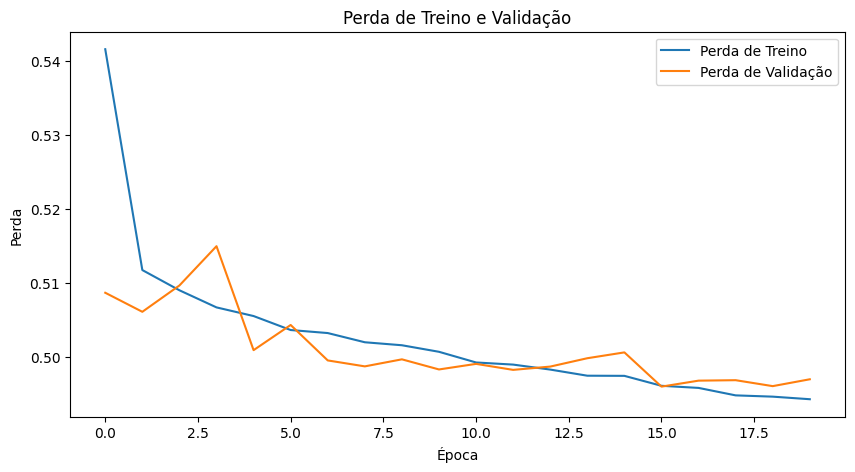

In [18]:
# Plotar as perdas de treino e validação.
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Perda de Treino')
plt.plot(val_loss_history, label='Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Perda de Treino e Validação')
plt.legend()
plt.show()

In [20]:
# Avaliar o modelo no conjunto de teste.
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)
y_test_binary = convert_to_binary(y_test_tensor)

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_binary).item()
    test_probabilities = torch.sigmoid(test_outputs)  # Obter probabilidades
    test_predictions_binary = (test_probabilities > 0.5).float()  # Previsões binárias

    # Converter previsões binárias para rótulos ordinais
    test_predictions_ordinal = test_predictions_binary.sum(dim=1).long()  # Soma das previsões binárias

    # Converter rótulos binários verdadeiros para rótulos ordinais
    y_test_ordinal = y_test_binary.sum(dim=1).long()  # Soma dos rótulos binários verdadeiros

    # Calcular métricas
    test_accuracy = accuracy_score(y_test_ordinal.numpy(), test_predictions_ordinal.numpy())
    test_confusion = confusion_matrix(y_test_ordinal.numpy(), test_predictions_ordinal.numpy())
    test_classification_report = classification_report(y_test_ordinal.numpy(), test_predictions_ordinal.numpy())

    # Imprimir resultados
    print(f"Perda de Teste: {test_loss:.4f}")
    print(f"Acurácia de Teste: {test_accuracy:.4f}")
    print("Matriz de Confusão:\n", test_confusion)
    print("Relatório de Classificação:\n", test_classification_report)


Perda de Teste: 0.5016
Acurácia de Teste: 0.5607
Matriz de Confusão:
 [[7612 3232  802]
 [1965 3120 1508]
 [ 924 3813 4897]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.72      0.65      0.69     11646
           1       0.31      0.47      0.37      6593
           2       0.68      0.51      0.58      9634

    accuracy                           0.56     27873
   macro avg       0.57      0.55      0.55     27873
weighted avg       0.61      0.56      0.58     27873

